In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
# device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
#                                    not x.configuration().simulator and x.status().operational==True))
# print("Running on current least busy device: ", device)

In [2]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [11]:
def grovers_algorithm(k,d): # k- decides the depth of the malicious circuit and d is the delay value
    n = 4
    grover_circuit = QuantumCircuit(n)

############## VICTIM's CIRCUIT ######################    
    grover_circuit.barrier() 
    
    grover_circuit = initialize_s(grover_circuit, [0,1])
    
    grover_circuit.cz(0,1) # Oracle

    # Diffusion operator (U_s)
    grover_circuit.h([0,1])
    grover_circuit.z([0,1])
    grover_circuit.cz(0,1)
    grover_circuit.h([0,1])
    

#     grover_circuit.barrier()
####################################################

############ MALICIOUS CIRCUIT #####################
    for i in range(k):
        grover_circuit.cx(2,3)
        grover_circuit.delay(d, qarg=2, unit = 'dt')
        grover_circuit.cx(2,3)
        grover_circuit.delay(d, qarg=2, unit = 'dt')
####################################################

    grover_circuit.barrier()
    
#         grover_circuit.delay(d, unit = 'dt')
#         grover_circuit.c(2)
#         grover_circuit.delay(d, unit = 'dt')
#     grover_circuit.barrier()
    
    return grover_circuit

In [5]:
grover_circuit = grovers_algorithm(4,0)
print(grover_circuit)
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

      ░ ┌───┐                ┌───┐     ┌───┐                ┌───┐           »
q_0: ─░─┤ H ├───────■────────┤ H ├─────┤ Z ├────────■───────┤ H ├───────────»
      ░ ├───┤       │        ├───┤     ├───┤        │       ├───┤           »
q_1: ─░─┤ H ├───────■────────┤ H ├─────┤ Z ├────────■───────┤ H ├───────────»
      ░ └───┘┌──────────────┐└───┘┌────┴───┴─────┐     ┌────┴───┴─────┐     »
q_2: ─░───■──┤ Delay(0[dt]) ├──■──┤ Delay(0[dt]) ├──■──┤ Delay(0[dt]) ├──■──»
      ░ ┌─┴─┐└──────────────┘┌─┴─┐└──────────────┘┌─┴─┐└──────────────┘┌─┴─┐»
q_3: ─░─┤ X ├────────────────┤ X ├────────────────┤ X ├────────────────┤ X ├»
      ░ └───┘                └───┘                └───┘                └───┘»
«                                                                    »
«q_0: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_1: ───────────────────────────────────────────────────────────────»
«     ┌───────

<IPython.core.display.Math object>

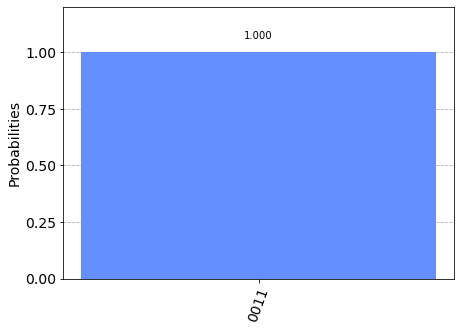

In [6]:
grover_circuit.measure_all()
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [7]:
device = provider.get_backend('ibmq_lima') #run on ibmq_lima (5-qbit QC)
print("Running on device: ", device)
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=0, scheduling_method='alap')

Running on device:  ibmq_lima


In [8]:
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


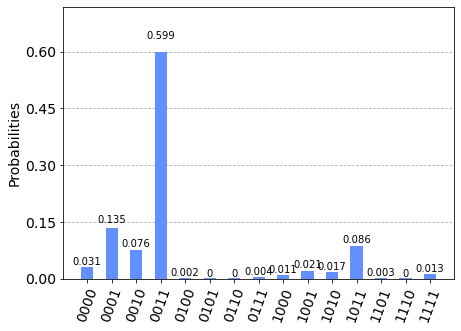

In [9]:

# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

# k=100
# prob = int(answer['0011'])/1000
# print(prob)
# f = open("test.txt", "w")
# f.write(str(k))
# f.write(str(", "))
# f.write(str(prob))
# f.close()

In [10]:
from qiskit.tools.monitor import job_monitor

# k_values = [0,2,10,20,30,40,50,60,70,100,200,300,500,1000,2000,5000]
d = 1

f = open("barrier_readjusted_test_2x.txt", "w")
# for i in range(len(k_values)):
#     grover_circuit = grovers_algorithm(k_values[i],d)

for i in range(30):
    grover_circuit = grovers_algorithm(i,d)
    grover_circuit.measure_all()
    device = provider.get_backend('ibmq_lima')
    print("Running on device: ", device)
    transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3, scheduling_method='alap')
    job = device.run(transpiled_grover_circuit)
    
    job_monitor(job, interval=2)
    
    results = job.result()
    answer = results.get_counts(grover_circuit)
    plot_histogram(answer)

    prob = int(answer['0011'])/1000 
    print(i, prob)
    f.write(str(i))
    f.write(str(", "))
    f.write(str(prob))
    f.write(str("\n"))
    
f.close()    
    

Running on device:  ibmq_lima
Job Status: job has successfully run
0 0.9
Running on device:  ibmq_lima
Job Status: job has successfully run
1 0.915
Running on device:  ibmq_lima
Job Status: job has successfully run
2 0.84
Running on device:  ibmq_lima
Job Status: job has successfully run
3 0.872
Running on device:  ibmq_lima
Job Status: job has successfully run
4 0.707
Running on device:  ibmq_lima
Job Status: job has successfully run
5 0.75
Running on device:  ibmq_lima
Job Status: job has successfully run
6 0.772
Running on device:  ibmq_lima
Job Status: job has successfully run
7 0.582
Running on device:  ibmq_lima
Job Status: job has successfully run
8 0.736
Running on device:  ibmq_lima
Job Status: job has successfully run
9 0.702
Running on device:  ibmq_lima
Job Status: job has successfully run
10 0.677
Running on device:  ibmq_lima
Job Status: job has successfully run
11 0.68
Running on device:  ibmq_lima
Job Status: job has successfully run
12 0.324
Running on device:  ibmq_li

In [41]:
print(transpiled_grover_circuit)


                    ┌─────────┐     ┌────┐┌─────────┐ ░ ┌───────────────────┐»
      q_0 -> 0 ─────┤ Rz(π/2) ├─────┤ √X ├┤ Rz(π/2) ├─░─┤ Delay(122874[dt]) ├»
                    ├─────────┤     ├────┤├─────────┤ ░ ├───────────────────┤»
      q_1 -> 1 ─────┤ Rz(π/2) ├─────┤ √X ├┤ Rz(π/2) ├─░─┤ Delay(123034[dt]) ├»
               ┌────┴─────────┴────┐└────┘└─────────┘ ░ └───────────────────┘»
ancilla_0 -> 2 ┤ Delay(150512[dt]) ├─────────────────────────────────────────»
               └─┬────────────────┬┘                  ░         ┌───┐        »
      q_3 -> 3 ──┤ Delay(160[dt]) ├───────────────────░─────────┤ X ├────────»
                 ├────────────────┤                   ░         └─┬─┘        »
      q_2 -> 4 ──┤ Delay(160[dt]) ├───────────────────░───────────■──────────»
                 └────────────────┘                   ░                      »
       meas: 4/══════════════════════════════════════════════════════════════»
                                                    

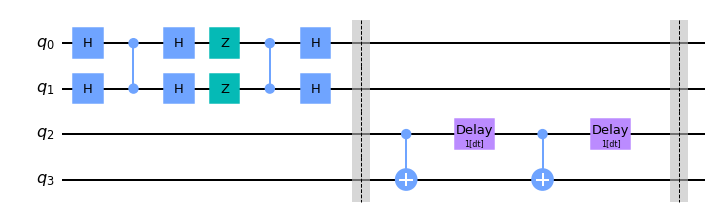

In [48]:
gc = grovers_algorithm(1,1)
gc.draw(output='mpl')